In [1]:
import torch


class CFG:
    NUM_EPOCHS = 300
    NUM_CLASSES = 2
    BATCH_SIZE = 64
    TIMESTEP_NUM = 128
    FOLD = 0
    DEVICE = torch.device('cuda:4')


RECEIVED_PARAMS = {
    "c_lr": 0.00001,
    "g_lr": 0.00001,
    "d_lr": 0.00001,
    "weight_gp": 10.0,
    "weight_ssl": 1.0,
    "weight_cls": 10.0,
    "start_point": 0,
    "delay_cls": 1,
    "mixup": 0
}

In [2]:
from pathlib import Path

DATASET_BASE_DIR = Path('/home/username/Data/eeg-datasets')
DATASET_FOLD_DIR = DATASET_BASE_DIR / 'DEAP'
PREPROCESSED_EEG_DIR = DATASET_FOLD_DIR / 'data_preprocessed_python'

In [3]:
from preprocessors import DEAPDataset, Sequence
from preprocessors import BinaryLabel
from preprocessors import Raw2TNCF, RemoveBaseline, TNCF2NCF, ChannelToLocation

label_preprocessors = {'label': Sequence([FourClassificationLabel()])}
feature_preprocessors = {
    'feature':
    Sequence([Raw2TNCF(),
              RemoveBaseline(),
              TNCF2NCF(),
              ChannelToLocation()])
}

preprocessors_results = DEAPDataset(
    PREPROCESSED_EEG_DIR, label_preprocessors,
    feature_preprocessors)('./dataset/deap_four_classification_dataset.pkl')

In [4]:
import os
import torch
import numpy as np
import pickle as pkl
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn import model_selection


class EEGDataset(Dataset):
    def __init__(self, preprocessors_results, feature_key='feature', label_key='label'):
        self.feature_key = feature_key
        self.label_key = label_key

        feature_list = []
        label_list = []

        for trail in preprocessors_results.keys():
            feature = preprocessors_results[trail][feature_key]
            feature_list.append(feature)
            label = preprocessors_results[trail][label_key]
            label_list.append(label)

        feature_list = np.concatenate(feature_list, axis=0)
        label_list = np.concatenate(label_list, axis=0)

        self.feature_list = feature_list
        self.label_list = label_list

    def __getitem__(self, index):
        feature = torch.from_numpy(self.feature_list[index]).float()
        label = torch.tensor(self.label_list[index]).long()
        return feature, label

    def __len__(self):
        return len(self.label_list)


def train_test_split(dataset,
                     kfold_split_index_path='./cache/kfold_split_index.pkl',
                     fold=0,
                     n_splits=5,
                     shuffle=True,
                     seed=520):
    if not os.path.exists(kfold_split_index_path):
        n_samples = len(dataset)
        indices = np.arange(n_samples)
        kfold = model_selection.StratifiedKFold(
            n_splits=n_splits, shuffle=shuffle, random_state=seed)

        index_dict = {}
        for i, (train_index, test_index) in enumerate(kfold.split(indices, dataset.label_list)):
            index_dict[i] = {'train_index': train_index,
                             'test_index': test_index}

        with open(kfold_split_index_path, 'wb') as file:
            pkl.dump(index_dict, file)
    else:
        with open(kfold_split_index_path, 'rb') as file:
            index_dict = pkl.load(file)

    index_split = index_dict[fold]
    train_index, test_index = index_split['train_index'], index_split['test_index']

    trian_dataset = Subset(dataset, train_index)
    test_dataset = Subset(dataset, test_index)

    return trian_dataset, test_dataset

In [5]:
class Generator(nn.Module):
    def __init__(self, in_channels=4, out_channels=128):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels,
                      128,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=True), nn.LeakyReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2, bias=True),
            nn.LeakyReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2, bias=True),
            nn.LeakyReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU())
        self.delayer1 = nn.Sequential(
            nn.ConvTranspose2d(16,
                               32,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=True), nn.LeakyReLU())
        self.delayer2 = nn.Sequential(
            nn.ConvTranspose2d(32,
                               64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=True), nn.LeakyReLU())
        self.delayer3 = nn.Sequential(
            nn.ConvTranspose2d(64,
                               128,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=True))

    def forward(self, x):
        mask = (x.abs().sum(dim=1, keepdim=True) > 0).float()
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.delayer1(x)
        x = self.delayer2(x)
        x = self.delayer3(x)
        return x * mask


class ResidualConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=bias), nn.SELU(),
            nn.Conv2d(out_channels,
                      out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=bias))
        self.res = nn.Conv2d(in_channels,
                             out_channels,
                             kernel_size=1,
                             stride=1,
                             padding=0,
                             bias=bias)

    def forward(self, x):
        return self.conv(x) + self.res(x)


class InceptionConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super().__init__()
        self.conv5x5 = nn.Conv2d(in_channels,
                                 out_channels,
                                 kernel_size=5,
                                 stride=1,
                                 padding=2,
                                 bias=bias)
        self.conv3x3 = nn.Conv2d(in_channels,
                                 out_channels,
                                 kernel_size=3,
                                 stride=1,
                                 padding=1,
                                 bias=bias)
        self.conv1x1 = nn.Conv2d(in_channels,
                                 out_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0,
                                 bias=bias)

    def forward(self, x):
        return self.conv5x5(x) + self.conv3x3(x) + self.conv1x1(x)


class SeparableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=True):
        super().__init__()
        self.depth = nn.Conv2d(in_channels,
                               in_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               groups=in_channels,
                               bias=bias)
        self.point = nn.Conv2d(in_channels,
                               out_channels,
                               kernel_size=1,
                               stride=stride,
                               padding=0,
                               bias=bias)

    def forward(self, x):
        x = self.depth(x)
        x = self.point(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, num_classes, in_channels=4):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Conv2d(in_channels,
                                256,
                                kernel_size=3,
                                stride=1,
                                padding=1,
                                bias=True)
        self.layer2 = nn.Conv2d(256,
                                128,
                                kernel_size=5,
                                stride=1,
                                padding=2,
                                bias=True)
        self.layer3 = nn.Conv2d(128,
                                64,
                                kernel_size=5,
                                stride=1,
                                padding=2,
                                bias=True)
        self.layer4 = SeparableConv2d(64,
                                      32,
                                      kernel_size=5,
                                      stride=1,
                                      padding=2,
                                      bias=True)
        self.layer5 = InceptionConv2d(32, 16)

        self.drop = nn.Sequential(nn.SELU())
        self.fc1 = nn.Sequential(nn.Linear(9 * 9 * 16, 1024, bias=True),
                                 nn.SELU())
        self.fc2 = nn.Linear(1024, num_classes, bias=True)

    def forward(self, x):
        out = self.layer1(x)
        out = self.drop(out)
        out = self.layer2(out)
        out = self.drop(out)
        out = self.layer3(out)
        out = self.drop(out)
        out = self.layer4(out)
        out = self.drop(out)
        out = self.layer5(out)
        out = self.drop(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [6]:
class Classifier(nn.Module):
    def __init__(self, num_classes, in_channels=4):
        super(Classifier, self).__init__()
        self.layer1 = nn.Conv2d(
            in_channels, 256, kernel_size=3, stride=1, padding=1, bias=True)
        self.layer2 = nn.Conv2d(256, 128, kernel_size=5,
                                stride=1, padding=2, bias=True)
        self.layer3 = nn.Conv2d(128, 64, kernel_size=5,
                                stride=1, padding=2, bias=True)
        self.layer4 = SeparableConv2d(
            64, 32, kernel_size=5, stride=1, padding=2, bias=True)
        self.layer5 = InceptionConv2d(32, 16)
        self.drop = nn.Sequential(nn.Dropout(), nn.SELU())
        self.fc1 = nn.Sequential(
            nn.Linear(9 * 9 * 16, 1024, bias=True), nn.SELU())
        self.fc2 = nn.Linear(1024, num_classes, bias=True)

    def forward(self, x):
        out = self.layer1(x)
        out = self.drop(out)
        out = self.layer2(out)
        out = self.drop(out)
        out = self.layer3(out)
        out = self.drop(out)
        out = self.layer4(out)
        out = self.drop(out)
        out = self.layer5(out)
        out = self.drop(out)
        out = out.view(out.size(0), -1)
        feat = self.fc1(out)
        out = self.fc2(feat)
        return out, feat

In [7]:
g_model = Generator(in_channels=CFG.TIMESTEP_NUM, out_channels=CFG.TIMESTEP_NUM)
d_model = Discriminator(num_classes=1, in_channels=CFG.TIMESTEP_NUM)
c_model = Classifier(num_classes=CFG.NUM_CLASSES, in_channels=CFG.TIMESTEP_NUM)

In [8]:
gan_state_dicts = torch.load('./parameters/cross_validation_proposed_wounet_pretrain_arousal.pth')
# gan_state_dicts = torch.load('./parameters/cross_validation_proposed_pretrain.pth')

g_model.load_state_dict(gan_state_dicts['g_model'])
d_model.load_state_dict(gan_state_dicts['d_model'])

<All keys matched successfully>

In [9]:
# c_model.load_state_dict(torch.load(
#     'cross_validation_finetune' + str(CFG.FOLD) + '.pth')['c_model'])
c_model.load_state_dict(torch.load(
    './parameters/cross_validation_backbone' + str(CFG.FOLD) + '.pth')['c_model'])
# c_model.load_state_dict(gan_state_dicts['c_model'])

<All keys matched successfully>

In [10]:
def random_mask(data, min_r=0.5, max_r=0.9):
    # batch_size*channel_num*time_step
    data = data.clone()
    mask = torch.rand(*data.shape[:2],
                      *([1] * (len(data.shape) - 2)),
                      device=data.device)
    # ratio = np.random.beta(1.0, 1.0, size=(data.shape[0], 1, 1, 1))
    # ratio = torch.tensor(ratio, device=mask.device).clamp(max=0.5)
    ratio = torch.rand(size=(data.shape[0], 1, 1, 1),
                       device=mask.device) * (max_r - min_r) + min_r
    mask = mask < ratio
    mask = mask.expand_as(data)
    data[mask] = 0.0
    return data, ratio


def extract_feature(dataloader):
    extracted_features_list = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(CFG.DEVICE)

#             aug_x, ratio = random_mask(x)
#             aug_x = g_model(aug_x).detach()
#             aug_y_hat, aug_x_feat = c_model(aug_x)

            y_hat, x_feat = c_model(x)

            extracted_features = x_feat.detach().cpu().numpy()
            extracted_features_list.append(extracted_features)

    extracted_features_list = np.concatenate(extracted_features_list)
    return extracted_features_list


def extract_gan_feature(dataloader):
    extracted_features_list = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(CFG.DEVICE)

            aug_x, ratio = random_mask(x)
            aug_x = g_model(aug_x).detach()
#             aug_x = g_model(x).detach()

            y_hat, x_feat = c_model(aug_x)

            extracted_features = x_feat.detach().cpu().numpy()
            extracted_features_list.append(extracted_features)

    extracted_features_list = np.concatenate(extracted_features_list)
    return extracted_features_list


def calculate_feature_statistics(extract_features):
    """Calculates the statistics used by FID
    Args:
        images: torch.tensor, shape: (N, 3, H, W), dtype: torch.float32 in range 0 - 1
        batch_size: batch size to use to calculate inception scores
    Returns:
        mu:     mean over all activations from the last pool layer of the inception model
        sigma:  covariance matrix over all activations from the last pool layer 
                of the inception model.
    """
    mu = np.mean(extract_features, axis=0)
    sigma = np.cov(extract_features, rowvar=False)
    return mu, sigma

# calculate_feature_statistics(train_dataloader)

In [11]:
from scipy import linalg


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2
    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean


def calculate_fid(dataloader):
    """ Calculate FID between images1 and images2
    Args:
        images1: np.array, shape: (N, H, W, 3), dtype: np.float32 between 0-1 or np.uint8
        images2: np.array, shape: (N, H, W, 3), dtype: np.float32 between 0-1 or np.uint8
        use_multiprocessing: If multiprocessing should be used to pre-process the images
        batch size: batch size used for inception network
    Returns:
        FID (scalar)
    """
    gt_features = extract_feature(dataloader)
    gan_features = extract_gan_feature(dataloader)

    gt_mu1, gt_sigma1 = calculate_feature_statistics(gt_features)
    gan_mu2, gan_sigma2 = calculate_feature_statistics(gan_features)

    fid = calculate_frechet_distance(gt_mu1, gt_sigma1, gan_mu2, gan_sigma2)
    return fid

# calculate_fid(train_dataloader)

In [12]:
from torch.utils.data import Dataset, Subset, DataLoader

eeg_dataset = EEGDataset(preprocessors_results,
                                 feature_key='feature',
                                 label_key='label')
train_dataset, val_dataset = train_test_split(eeg_dataset, fold=CFG.FOLD)
train_dataloader = DataLoader(train_dataset,
                                      batch_size=CFG.BATCH_SIZE,
                                      shuffle=False,
                                      drop_last=False)

g_model = g_model.to(CFG.DEVICE)
d_model = d_model.to(CFG.DEVICE)
c_model = c_model.to(CFG.DEVICE)

In [14]:
from torch_eeg.pipline.functional.deap import get_channel_location, CHANNEL_LIST, LOCATION_LIST

channel_location = get_channel_location(CHANNEL_LIST, LOCATION_LIST)


def location_to_channel(data):
    # sample_num*9*9*bands
    data = data.permute(2, 3, 0, 1)
    # 9*9*sample_num*bands
    outputs = torch.zeros([len(CHANNEL_LIST), *data.shape[2:]],
                          dtype=data.dtype, device=data.device)
    for i, (x, y) in enumerate(channel_location.values()):
        x = x - 1
        y = y - 1
        outputs[i] = data[x][y]
    # channel*sample_num*bands
    outputs = outputs.permute(1, 0, 2)
    return outputs

In [15]:
from tqdm.notebook import tqdm


gt_x_list = []
aug_x_list = []

for x, y in tqdm(train_dataloader):
    gt_x = location_to_channel(x).numpy()
    x = x.to(CFG.DEVICE)
    aug_x, ratio = random_mask(x)
    aug_x = location_to_channel(g_model(aug_x)).detach().cpu().numpy()

    gt_x_list.append(gt_x)
    aug_x_list.append(aug_x)

gt_x = np.concatenate(gt_x_list, axis=0)
aug_x = np.concatenate(aug_x_list, axis=0)

In [16]:
import mne

CHANNEL_LIST = [
    'FP1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'OZ', 'PZ', 'FP2', 'AF4',
    'FZ', 'F4', 'F8', 'FC6', 'FC2', 'CZ', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2'
]
sampling_freq = 128
ch_types = ['eeg'] * len(CHANNEL_LIST)
info = mne.create_info(ch_names=CHANNEL_LIST, ch_types=ch_types, sfreq=sampling_freq)

In [17]:
import numpy as np

event_start = [step * sampling_freq for step in range(len(gt_x))]
event_value = [0] * len(event_start)
event_id = [1] * len(event_start)

events = np.array(list(zip(event_start, event_value, event_id)))
event_id = {
    'positive': 1,
    # 'neutral': 0,
    # 'negative': -1
}

In [18]:
import pandas as pd

df = pd.read_csv('./example/standard_102062.txt')
ch_names = list(df.name)
pos = df[['x','y','z']].values
dig_ch_pos = dict(zip(ch_names, pos))
montage = mne.channels.make_dig_montage(ch_pos=dig_ch_pos)

Not setting metadata
Not setting metadata
61440 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-19-3c69fe861a7f>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


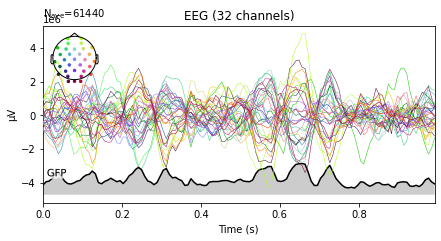

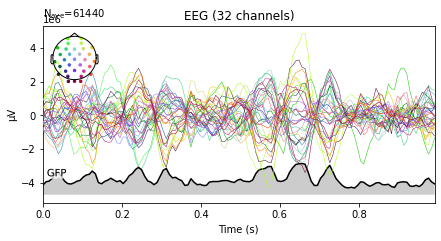

In [19]:
%matplotlib inline

epochs = mne.EpochsArray(gt_x, info, events=events, event_id=event_id, baseline=None)
epochs.set_montage(montage)
epochs.average().plot(picks='eeg', spatial_colors=True, gfp=True)

In [20]:
# high valence + low arousal = 1
# low valence + high arousal = 2
# high valence + high arousal = 3
# low valence + low arousal = 0
label_dict = {
    0: [],
    1: [],
    2: [],
    3: []
}

for i, (_, label) in enumerate(train_dataset):
    label_dict[label.item()].append(i)

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-26-ab463489d2b0>:6: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


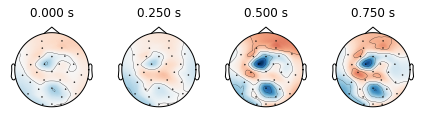

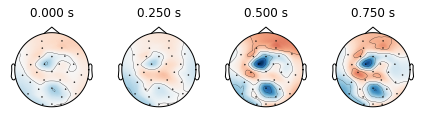

In [26]:
# eeg_idx = label_dict[1][149]
eeg_idx = label_dict[1][110]

epochs = mne.EpochsArray(gt_x[eeg_idx:eeg_idx+1], info,
                         events=events[eeg_idx:eeg_idx+1], event_id=event_id, baseline=None)
epochs.set_montage(montage)
times = np.arange(0.0, 1.0, 0.25)
epochs.average().plot_topomap(times, ch_type='eeg', time_unit='s', colorbar=False, sphere=(0., 0., 0., 0.11))

In [27]:
# %matplotlib inline

# epochs = mne.EpochsArray(aug_x, info, events=events, event_id=event_id, baseline=None)
# epochs.set_montage(montage)
# epochs.average().plot(picks='eeg', spatial_colors=True, gfp=True)

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-28-f6f37136d449>:2: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


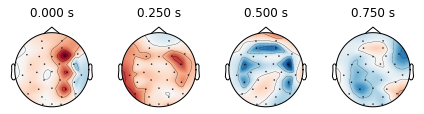

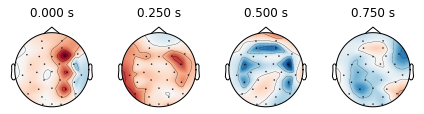

In [28]:
epochs = mne.EpochsArray(aug_x[eeg_idx:eeg_idx+1], info, events=events[eeg_idx:eeg_idx+1], event_id=event_id, baseline=None)
epochs.set_montage(montage)
times = np.arange(0.0, 1.0, 0.25)
epochs.average().plot_topomap(times, ch_type='eeg', time_unit='s', colorbar=False, sphere=(0., 0., 0., 0.11))

Creating RawArray with float64 data, n_channels=32, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.992 secs
Ready.


<ipython-input-24-06d91355446f>:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


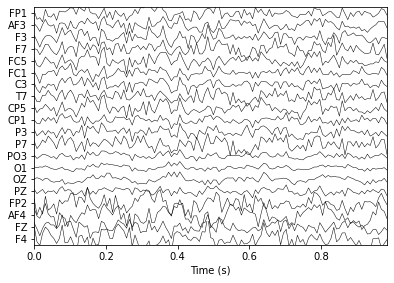

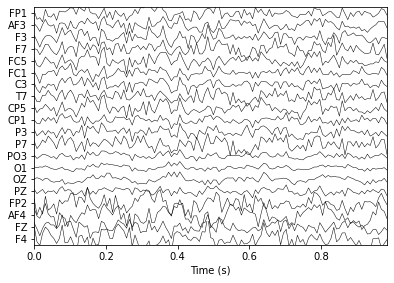

In [24]:
v_ch_types = ['misc'] * len(CHANNEL_LIST)
v_info = mne.create_info(ch_names=CHANNEL_LIST, ch_types=v_ch_types, sfreq=sampling_freq)

epochs = mne.io.RawArray(aug_x[eeg_idx], v_info)
epochs.set_montage(montage)
epochs.plot(show_scrollbars=False, show_scalebars=False, block=True)

Creating RawArray with float64 data, n_channels=32, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.992 secs
Ready.


<ipython-input-25-7da235c54e08>:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


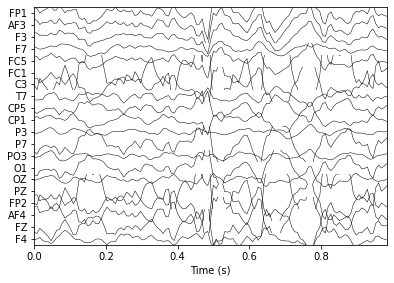

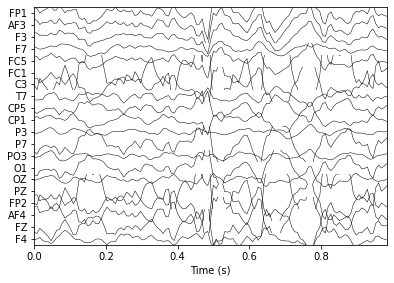

In [25]:
v_ch_types = ['misc'] * len(CHANNEL_LIST)
v_info = mne.create_info(ch_names=CHANNEL_LIST, ch_types=v_ch_types, sfreq=sampling_freq)

epochs = mne.io.RawArray(gt_x[eeg_idx], v_info)
epochs.set_montage(montage)
epochs.plot(show_scrollbars=False, show_scalebars=False, block=True)